In [47]:
library(DT)

library(lattice)

library(knitr)

library(gplots)

library(ggplot2)

library(ClustOfVar)

library(ape)

library(Information)

library(ROCR)

library(caret)

library(rpart)

In [48]:
setwd("/Users/amrendrapandey/Library/Mobile Documents/com~apple~CloudDocs/subjects/credit risk model /data")

In [49]:
cdata<-read.csv("german.csv",header=T)

In [50]:
colnames(cdata) <- c("chk_ac_status_1",
                     "duration_month_2", "credit_history_3", "purpose_4",
                     "credit_amount_5","savings_ac_bond_6","p_employment_since_7",
                     "instalment_pct_8", "personal_status_9","other_debtors_or_grantors_10",
                     "present_residence_since_11","property_type_12","age_in_yrs_13",
                     "other_instalment_type_14", "housing_type_15",
                     "number_cards_this_bank_16","job_17","no_people_liable_for_mntnance_18",
                     "telephone_19", "foreign_worker_20",
                     "good_bad_21")

In [51]:
# creating functions for analysis. 

# create function to calculate percent distribution for factors 

pct <- function(x){
  tbl <- table(x)
  tbl_pct <- cbind(tbl,round(prop.table(tbl)*100,2))
  colnames(tbl_pct) <- c('Count','Percentage')
  kable(tbl_pct)
}

In [52]:
#  Own function to calculate IV, WOE and Efficiency- Prior to building a binary classification model, a common step is to perform variable screening and exploratory data analysis. This is the step where we get to know the data and weed out variables that are either ill-conditioned or simply contain no information that will help us predict the action of interest. The weight of evidence (WOE) and information value (IV) provide a great framework for for exploratory analysis and variable screening for binary classifiers. WOE and IV have been used extensively in the credit risk world for several decades, and the underlying theory dates back to the 1950s. However, it is still not widely used outside the credit risk world.

#WOE and IV enable one to:

#Consider each variable’s independent contribution to the outcome.

#Detect linear and non-linear relationships.
#Rank variables in terms of “univariate” predictive strength.
#Visualize the correlations between the predictive variables and the binary outcome.
#Seamlessly compare the strength of continuous and categorical variables without creating dummy variables.
#Seamlessly handle missing values without imputation.
#Assess the predictive power of missing values.


gbpct <- function(x, y=cdata$good_bad_21){
  mt <- as.matrix(table(as.factor(x), as.factor(y))) # x -> independent variable(vector), y->dependent variable(vector)
  Total <- mt[,1] + mt[,2] # Total observations
  Total_Pct <- round(Total/sum(mt)*100, 2) # Total PCT
  Bad_pct <- round((mt[,1]/sum(mt[,1]))*100, 2) # PCT of BAd or event or response
  Good_pct <- round((mt[,2]/sum(mt[,2]))*100, 2) # PCT of Good or non-event
  Bad_Rate <- round((mt[,1]/(mt[,1]+mt[,2]))*100, 2) # Bad rate or response rate
  grp_score <- round((Good_pct/(Good_pct + Bad_pct))*10, 2) # score for each group
  WOE <- round(log(Good_pct/Bad_pct)*10, 2) # Weight of Evidence for each group
  g_b_comp <- ifelse(mt[,1] == mt[,2], 0, 1)
  IV <- ifelse(g_b_comp == 0, 0, (Good_pct - Bad_pct)*(WOE/10)) # Information value for each group
  Efficiency <- abs(Good_pct - Bad_pct)/2 # Efficiency for each group
  otb<-as.data.frame(cbind(mt, Good_pct, Bad_pct, Total,
                           Total_Pct, Bad_Rate, grp_score,
                           WOE, IV, Efficiency ))
  otb$Names <- rownames(otb)
  rownames(otb) <- NULL
  otb[,c(12,2,1,3:11)] # return IV table
} 

In [53]:
#  function to normalize using Range 

normalize <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}

In [54]:
# getting first hand feeling of the data , variable names of the data. You may create your own variable names. 

kable(as.data.frame(colnames(cdata)))



|colnames(cdata)                  |
|:--------------------------------|
|chk_ac_status_1                  |
|duration_month_2                 |
|credit_history_3                 |
|purpose_4                        |
|credit_amount_5                  |
|savings_ac_bond_6                |
|p_employment_since_7             |
|instalment_pct_8                 |
|personal_status_9                |
|other_debtors_or_grantors_10     |
|present_residence_since_11       |
|property_type_12                 |
|age_in_yrs_13                    |
|other_instalment_type_14         |
|housing_type_15                  |
|number_cards_this_bank_16        |
|job_17                           |
|no_people_liable_for_mntnance_18 |
|telephone_19                     |
|foreign_worker_20                |
|good_bad_21                      |

In [55]:
# structure of the data, 

str(cdata)

'data.frame':	1000 obs. of  21 variables:
 $ chk_ac_status_1                 : Factor w/ 4 levels "A11","A12","A13",..: 1 2 4 1 1 4 4 2 4 2 ...
 $ duration_month_2                : int  6 48 12 42 24 36 24 36 12 30 ...
 $ credit_history_3                : Factor w/ 5 levels "A30","A31","A32",..: 5 3 5 3 4 3 3 3 3 5 ...
 $ purpose_4                       : Factor w/ 10 levels "A40","A41","A410",..: 5 5 8 4 1 8 4 2 5 1 ...
 $ credit_amount_5                 : int  1169 5951 2096 7882 4870 9055 2835 6948 3059 5234 ...
 $ savings_ac_bond_6               : Factor w/ 5 levels "A61","A62","A63",..: 5 1 1 1 1 5 3 1 4 1 ...
 $ p_employment_since_7            : Factor w/ 5 levels "A71","A72","A73",..: 5 3 4 4 3 3 5 3 4 1 ...
 $ instalment_pct_8                : int  4 2 2 2 3 2 3 2 2 4 ...
 $ personal_status_9               : Factor w/ 4 levels "A91","A92","A93",..: 3 2 3 3 3 3 3 3 1 4 ...
 $ other_debtors_or_grantors_10    : Factor w/ 3 levels "A101","A102",..: 1 1 1 3 1 1 1 1 1 1 ...
 $ presen

In [56]:
#summary of the data 

summary(cdata)

 chk_ac_status_1 duration_month_2 credit_history_3   purpose_4  
 A11:274         Min.   : 4.0     A30: 40          A43    :280  
 A12:269         1st Qu.:12.0     A31: 49          A40    :234  
 A13: 63         Median :18.0     A32:530          A42    :181  
 A14:394         Mean   :20.9     A33: 88          A41    :103  
                 3rd Qu.:24.0     A34:293          A49    : 97  
                 Max.   :72.0                      A46    : 50  
                                                   (Other): 55  
 credit_amount_5 savings_ac_bond_6 p_employment_since_7 instalment_pct_8
 Min.   :  250   A61:603           A71: 62              Min.   :1.000   
 1st Qu.: 1366   A62:103           A72:172              1st Qu.:2.000   
 Median : 2320   A63: 63           A73:339              Median :3.000   
 Mean   : 3271   A64: 48           A74:174              Mean   :2.973   
 3rd Qu.: 3972   A65:183           A75:253              3rd Qu.:4.000   
 Max.   :18424                            

In [57]:
# Modify variable types. We may need to convert data types of certain variables based on their properties. 

cdata$duration_month_2 <- as.numeric(cdata$duration_month_2)

cdata$credit_amount_5 <- as.numeric(cdata$credit_amount_5 )

cdata$instalment_pct_8 <- as.numeric(cdata$instalment_pct_8)

cdata$present_residence_since_11 <- as.numeric(cdata$present_residence_since_11)

cdata$age_in_yrs_13 <- as.numeric(cdata$age_in_yrs_13)

cdata$number_cards_this_bank_16 <- as.numeric(cdata$number_cards_this_bank_16)

cdata$no_people_liable_for_mntnance_18 < as.numeric(cdata$no_people_liable_for_mntnance_18)

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [133] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [145] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [157] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [169] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [181] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [193] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [205] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [217] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [229] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [241] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [253] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [265] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [277] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [289] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [301] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [313] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [325] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [337] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [349] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [361] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [373] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [385] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [397] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [409] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [421] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [433] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [445] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [457] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [469] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [481] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [493] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [505] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [517] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [529] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [541] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [553] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [565] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [577] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [589] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [601] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALS

In [58]:
# Good-bad and univariate analysis- analyze good_bad (0-good, 1-bad)



cdata$good_bad_21<-as.factor(ifelse(cdata$good_bad_21 == 1, "Bad", "Good"))

pct(cdata$good_bad_21)



|     | Count| Percentage|
|:----|-----:|----------:|
|Bad  |   300|         30|
|Good |   700|         70|

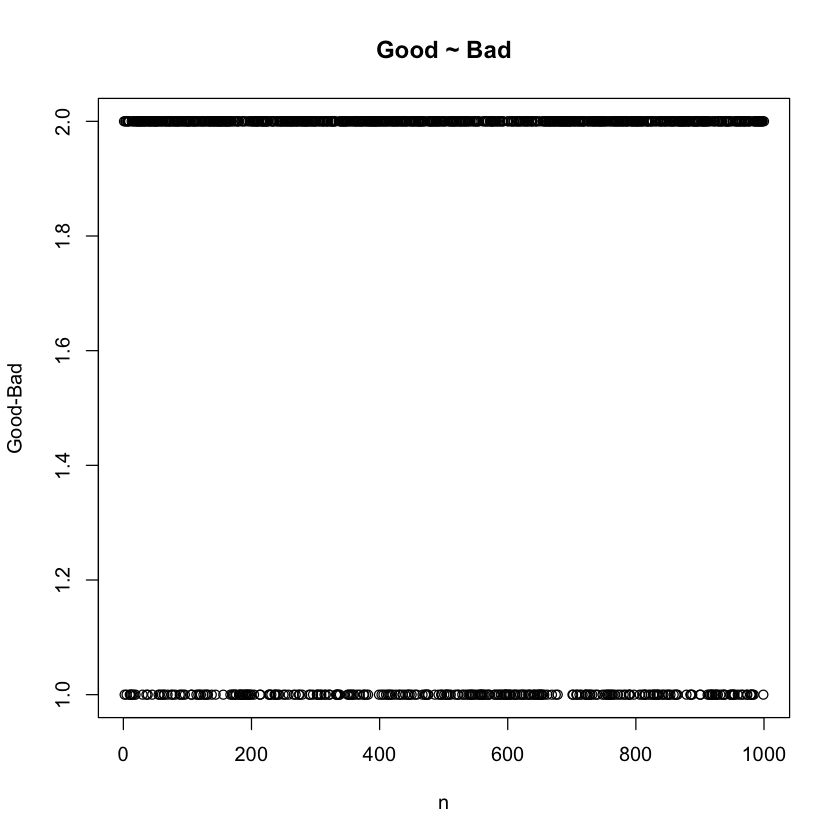

In [59]:


plot(as.numeric(cdata$good_bad_21), ylab="Good-Bad", xlab="n", main="Good ~ Bad")

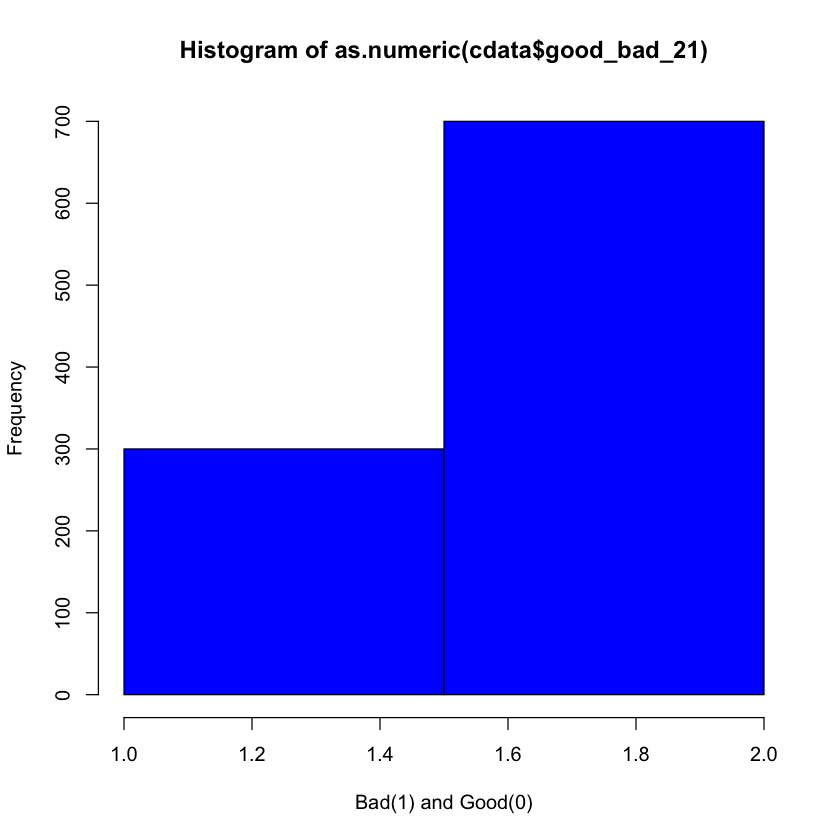

In [60]:
hist(as.numeric(cdata$good_bad_21), breaks=2,
     xlab="Bad(1) and Good(0)", col="blue")

In [61]:
# Univariate and bi variate analysis checking account status 

A1<-gbpct(cdata$chk_ac_status_1)

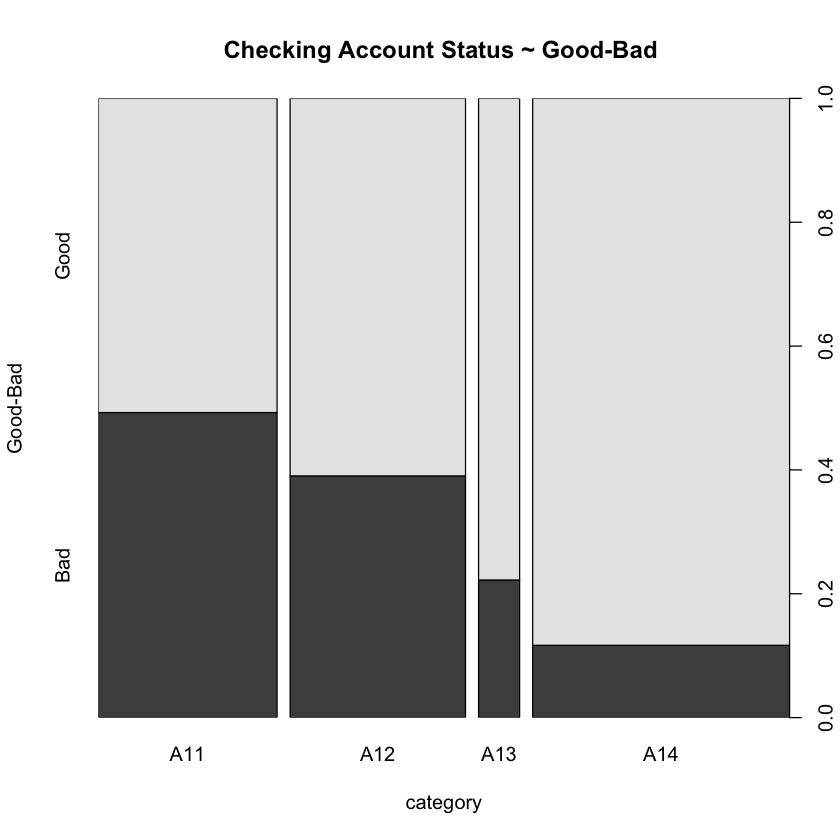

In [62]:


plot(cdata$chk_ac_status_1, cdata$good_bad_21,
     ylab="Good-Bad", xlab="category",
     main="Checking Account Status ~ Good-Bad ")

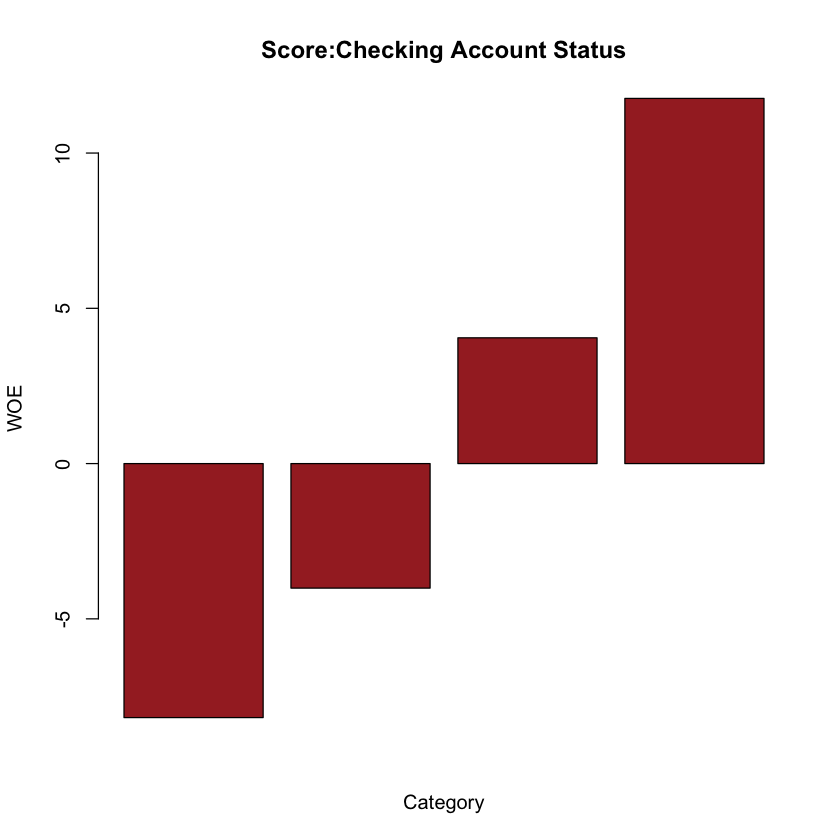

In [63]:
barplot(A1$WOE, col="brown", names.arg=c(A1$Levels),
        main="Score:Checking Account Status",
        xlab="Category",
        ylab="WOE"
)

In [64]:

kable(A1, caption = 'Checking Account Status ~ Good-Bad')



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|       IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|--------:|----------:|
|A11   |  139| 135|    19.86|   45.00|   274|      27.4|    49.27|      3.06| -8.18| 20.56452|     12.570|
|A12   |  164| 105|    23.43|   35.00|   269|      26.9|    39.03|      4.01| -4.01|  4.63957|      5.785|
|A13   |   49|  14|     7.00|    4.67|    63|       6.3|    22.22|      6.00|  4.05|  0.94365|      1.165|
|A14   |  348|  46|    49.71|   15.33|   394|      39.4|    11.68|      7.64| 11.76| 40.43088|     17.190|

In [65]:
#Loan Duration 

summary(cdata$duration_month_2)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    4.0    12.0    18.0    20.9    24.0    72.0 

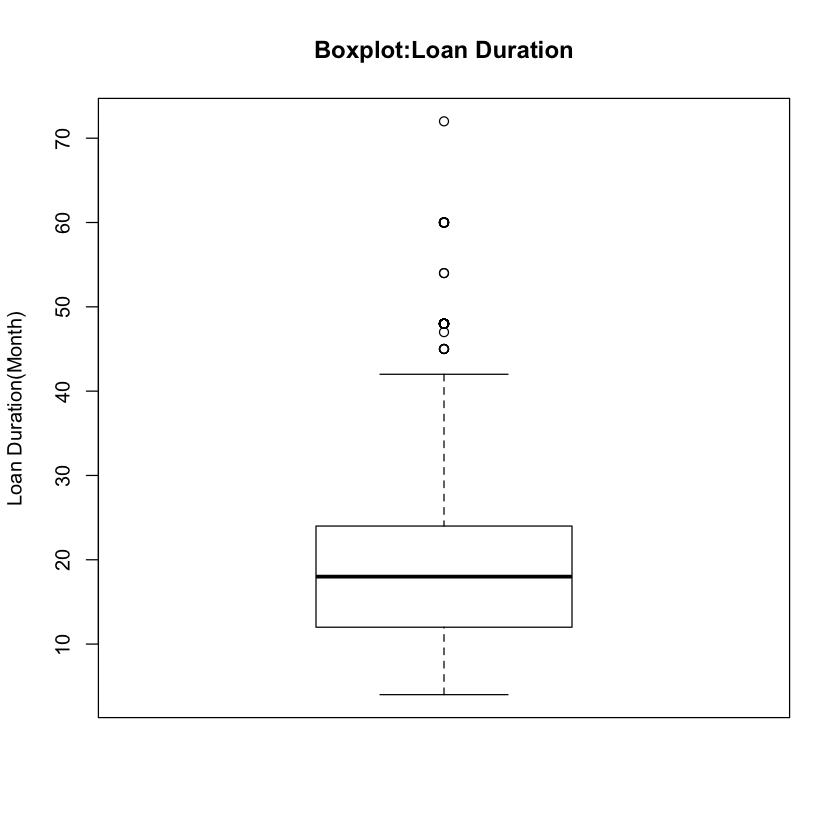

In [66]:


boxplot(cdata$duration_month_2, ylab="Loan Duration(Month)", main="Boxplot:Loan Duration")

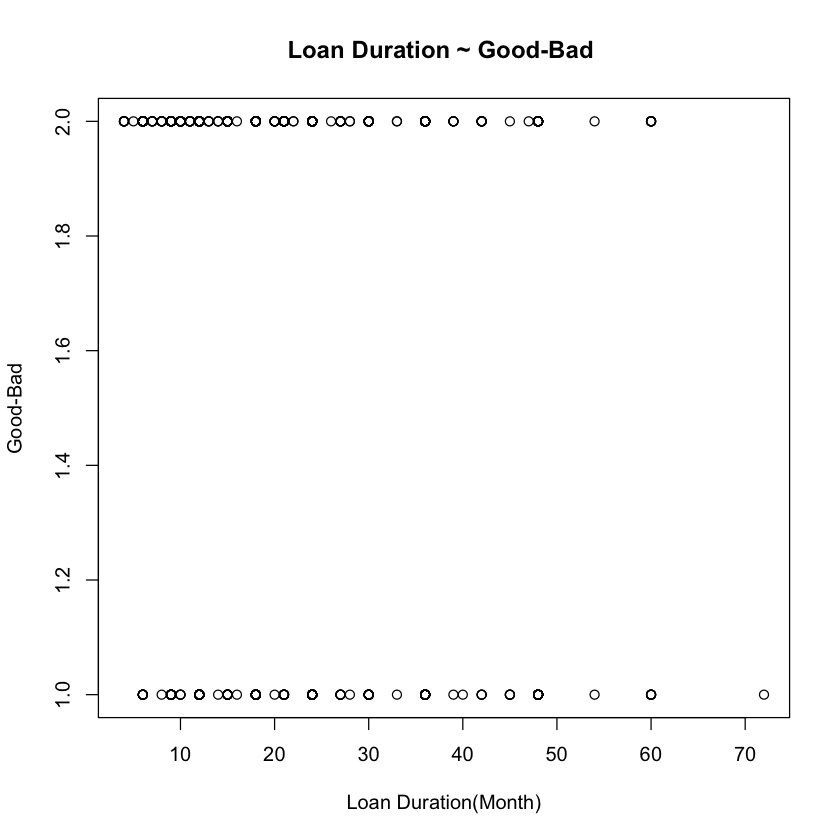

In [67]:
plot(cdata$duration_month_2, cdata$good_bad_21,
     ylab="Good-Bad", xlab="Loan Duration(Month)",
     main="Loan Duration ~ Good-Bad ")

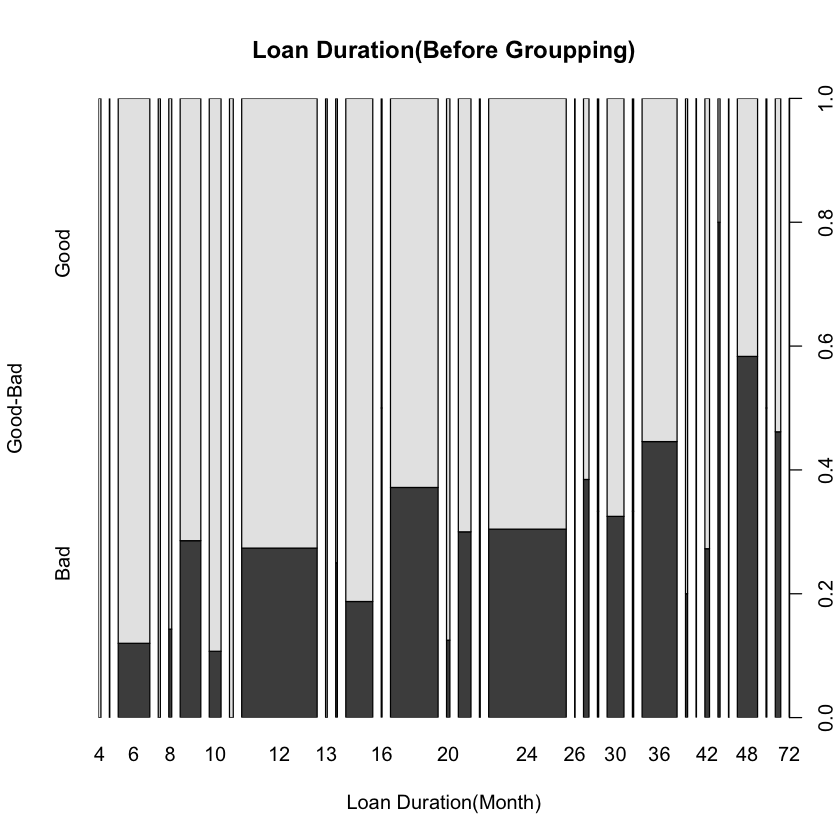

In [68]:
plot(as.factor(cdata$duration_month_2), cdata$good_bad_21,
     ylab="Good-Bad", xlab="Loan Duration(Month)",
     main="Loan Duration(Before Groupping)")

In [69]:
#create some groups from continuous variables 

cdata$duration_month_2<-as.factor(ifelse(cdata$duration_month_2<=6,'00-06',ifelse(cdata$duration_month_2<=12,'06-12',ifelse(cdata$duration_month_2<=24,'12-24',ifelse(cdata$duration_month_2<=30,'24-30',ifelse(cdata$duration_month_2<=36,'30-36',ifelse(cdata$duration_month_2<=42,'36-42','42+')))))))




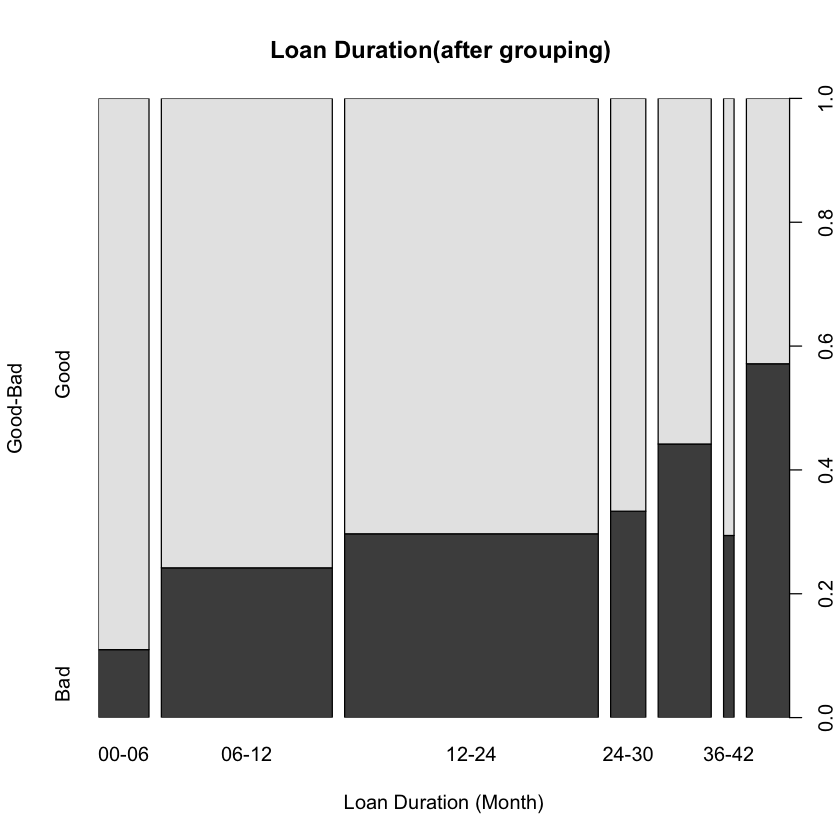

In [70]:
plot(cdata$duration_month_2, cdata$good_bad_21,
     main="Loan Duration(after grouping) ",
     xlab="Loan Duration (Month)",
     ylab="Good-Bad")

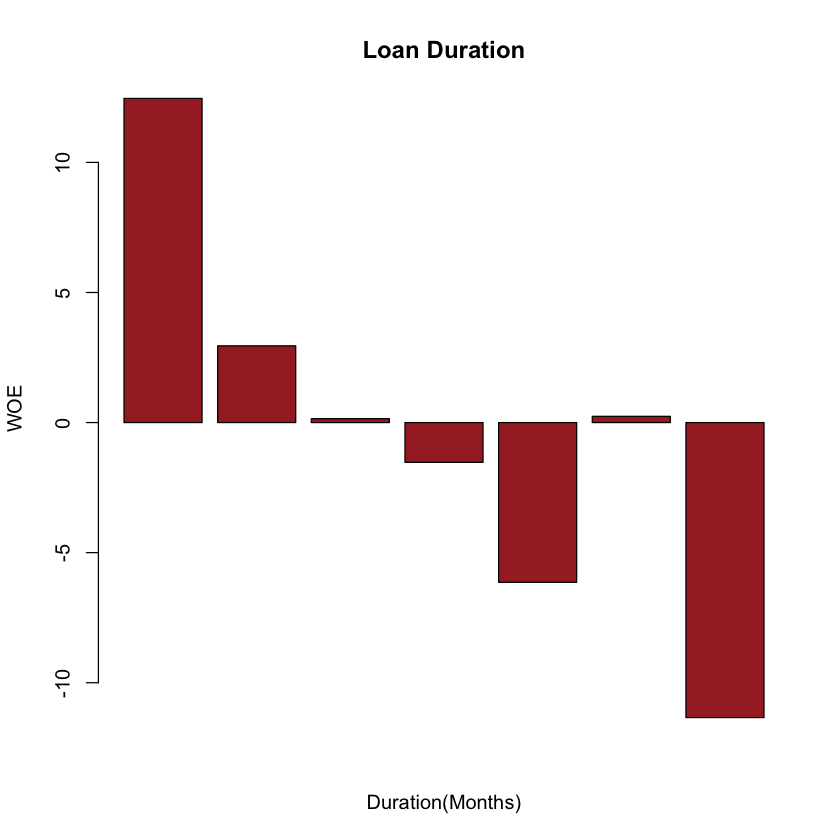

In [71]:
par(op2)
A2<-gbpct(cdata$duration_month_2)
barplot(A2$WOE, col="brown", names.arg=c(A2$Levels),
        main="Loan Duration",
        xlab="Duration(Months)",
        ylab="WOE"
)



In [72]:
kable(A2, caption = 'Loan Duration ~ Good-Bad')



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|    WOE|       IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|------:|--------:|----------:|
|00-06 |   73|   9|    10.43|    3.00|    82|       8.2|    10.98|      7.77|  12.46|  9.25778|      3.715|
|06-12 |  210|  67|    30.00|   22.33|   277|      27.7|    24.19|      5.73|   2.95|  2.26265|      3.835|
|12-24 |  289| 122|    41.29|   40.67|   411|      41.1|    29.68|      5.04|   0.15|  0.00930|      0.310|
|24-30 |   38|  19|     5.43|    6.33|    57|       5.7|    33.33|      4.62|  -1.53|  0.13770|      0.450|
|30-36 |   48|  38|     6.86|   12.67|    86|       8.6|    44.19|      3.51|  -6.14|  3.56734|      2.905|
|36-42 |   12|   5|     1.71|    1.67|    17|       1.7|    29.41|      5.06|   0.24|  0.00096|      0.020|
|42+   |   30|  40|     4.29|   13.33|    70|       7.0|    57.14|      2.43| -11.34| 10.25136|      4.520|